# IF5200 - Modeling Notebook
___
Group: 8<br>
Project: Automated Chest X-Ray Report Generator in Bahasa Indonesia with the Use of Deep Learning<br>
Team members: Arief Purnama Muharram, Hollyana Puteri Haryono, Abassi Haji Juma

## A. Print library version

In [6]:
print('tqdm version:', __import__('tqdm').__version__)
print('matplotlib version:', __import__('matplotlib').__version__)
print('seaborn version:', __import__('seaborn').__version__)
print('pandas version:', __import__('pandas').__version__)
print('scikit-learn version:', __import__('sklearn').__version__)
print('imblearn version:', __import__('imblearn').__version__)
print('pillow version:', __import__('PIL').__version__)
print('torch version:', __import__('torch').__version__)
print('torchvision version:', __import__('torchvision').__version__)

tqdm version: 4.64.1
matplotlib version: 3.5.3
seaborn version: 0.12.2
pandas version: 1.3.5
scikit-learn version: 1.0.2
imblearn version: 0.10.1
pillow version: 9.4.0
torch version: 1.13.1+cu117
torchvision version: 0.14.1+cu117


## B. Load all helpers

In [7]:
from engine.utils.dataloader import CustomDataLoader
from engine.utils.train import TrainUtils

from engine.trainer import build_from_pretrained, train_wrapper

## C. Load dataset

In [8]:
import pandas as pd


df = pd.read_csv('datasets/labels_cxr-images.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Image Index         112120 non-null  object
 1   Filename_Segment1   112120 non-null  object
 2   Filename_Segment2   112120 non-null  object
 3   Filename_Segment3   112120 non-null  object
 4   Atelectasis         112120 non-null  int64 
 5   Cardiomegaly        112120 non-null  int64 
 6   Effusion            112120 non-null  int64 
 7   Infiltration        112120 non-null  int64 
 8   Mass                112120 non-null  int64 
 9   Nodule              112120 non-null  int64 
 10  Pneumonia           112120 non-null  int64 
 11  Pneumothorax        112120 non-null  int64 
 12  Consolidation       112120 non-null  int64 
 13  Edema               112120 non-null  int64 
 14  Emphysema           112120 non-null  int64 
 15  Fibrosis            112120 non-null  int64 
 16  Pl

In [9]:
df.head(3)

,Image Index,Filename_Segment1,Filename_Segment2,Filename_Segment3,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,00000001_000_segment1.png,00000001_000_segment2.png,00000001_000_segment3.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,00000001_001_segment1.png,00000001_001_segment2.png,00000001_001_segment3.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,00000001_002_segment1.png,00000001_002_segment2.png,00000001_002_segment3.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0


## D. Modeling

In [132]:
# Experiment global variables
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 64

### Example: Cardiomegaly

**Pretrain model:** ResNet18; **Image dimension:** 128x128; **Learning rate:** 1e-3; **Batch size:** 64; **Loss function:** CrossEntropyLoss; **Optimizer:** Adam

In [133]:
# Step 1: Create the dataset
# ---
# Please the columns name are 'filename' and 'label' only.
# 'filename' column describe the image filename only (e.g. '00000001_0001.png')
# 'label' column describe the label of the image (0 for absent and 1 for present)

from sklearn.model_selection import train_test_split


df_cardiomegaly = df[['Filename_Segment2', 'Cardiomegaly']]
df_cardiomegaly = df_cardiomegaly.rename(columns={'Filename_Segment2': 'filename', 'Cardiomegaly': 'label'}, errors='ignore')

<AxesSubplot:xlabel='label', ylabel='count'>

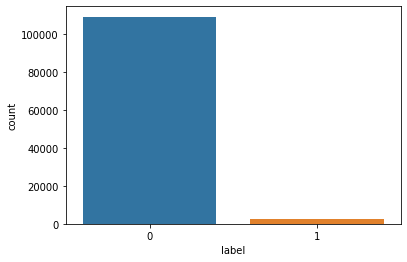

In [134]:
# Count labels

import seaborn as sns


sns.countplot(data=df_cardiomegaly, x='label')

In [135]:
# Down sampling

import pandas as pd

label_1 = df_cardiomegaly[df_cardiomegaly['label'] == 1]
label_0 = df_cardiomegaly.sample(n=len(label_1))
df_cardiomegaly = pd.concat([label_1, label_0], axis=0)
df_cardiomegaly = df_cardiomegaly.sample(frac=1, random_state=0)

df_cardiomegaly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5552 entries, 76162 to 110818
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  5552 non-null   object
 1   label     5552 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 130.1+ KB


In [136]:
df_cardiomegaly.head(3)

,filename,label
76162,00018686_000_segment2.png,1
107472,00029031_000_segment2.png,1
5871,00001582_012_segment2.png,1


In [137]:
# Dataset splitting

train_dataset, test_dataset = train_test_split(
    df_cardiomegaly, test_size=0.3, random_state=0
)

train_dataset, val_dataset = train_test_split(
    train_dataset, test_size=0.3, random_state=0
)

In [138]:
# Imbalance dataset handling

# from imblearn.over_sampling import RandomOverSampler


# ros = RandomOverSampler(random_state=0)
# train_dataset, _ = ros.fit_resample(train_dataset, train_dataset['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

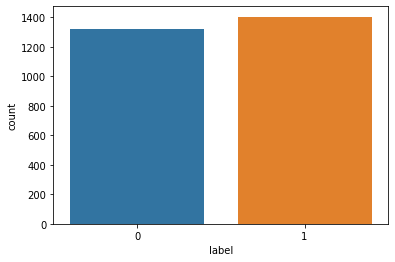

In [139]:
# After resampling

import seaborn as sns


sns.countplot(data=train_dataset, x='label')

In [140]:
# Step 2: Create the dataloader

dataloader = CustomDataLoader(batch_size=BATCH_SIZE, image_path='datasets/data_cxr-images_128x128')

train_dataloader = dataloader.create_dataloader(train_dataset)
val_dataloader = dataloader.create_dataloader(val_dataset)
test_dataloader = dataloader.create_dataloader(test_dataset)

In [142]:
# Step 3: Build the model
# ---
# Current tested pretrained models: ResNet18, ResNet50

from torchvision.models import resnet18, ResNet18_Weights


model = build_from_pretrained(resnet18(weights=ResNet18_Weights.DEFAULT))

/home/jupyter-23521013/.local/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [143]:
# Step 4: Setup the trainer
# ---
# Supported loss function: CrossEntropyLoss
# Supported optimizer: SGD, Adam

from torch import device


trainer = TrainUtils(model, 'CrossEntropyLoss', 'Adam', learning_rate=LEARNING_RATE, device=device('cuda:0'))

Using GPU!
Device name: Quadro RTX 5000


Begin training!

Epoch 1 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.25it/s]


Training time: 4.20 seconds


100%|██████████| 19/19 [00:01<00:00, 14.29it/s]


Validation time: 1.33 seconds


100%|██████████| 27/27 [00:01<00:00, 14.24it/s]


Testing time: 1.90 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 2 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.57it/s]


Training time: 4.07 seconds


100%|██████████| 19/19 [00:01<00:00, 14.36it/s]


Validation time: 1.33 seconds


100%|██████████| 27/27 [00:01<00:00, 13.95it/s]


Testing time: 1.94 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 3 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.19it/s]


Training time: 4.22 seconds


100%|██████████| 19/19 [00:01<00:00, 14.71it/s]


Validation time: 1.30 seconds


100%|██████████| 27/27 [00:01<00:00, 14.37it/s]


Testing time: 1.88 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 4 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.57it/s]


Training time: 4.07 seconds


100%|██████████| 19/19 [00:01<00:00, 14.60it/s]


Validation time: 1.31 seconds


100%|██████████| 27/27 [00:01<00:00, 14.49it/s]


Testing time: 1.87 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 5 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.57it/s]


Training time: 4.07 seconds


100%|██████████| 19/19 [00:01<00:00, 14.47it/s]


Validation time: 1.32 seconds


100%|██████████| 27/27 [00:01<00:00, 14.43it/s]


Testing time: 1.88 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 6 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.49it/s]


Training time: 4.10 seconds


100%|██████████| 19/19 [00:01<00:00, 14.53it/s]


Validation time: 1.31 seconds


100%|██████████| 27/27 [00:01<00:00, 14.38it/s]


Testing time: 1.88 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 7 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.48it/s]


Training time: 4.11 seconds


100%|██████████| 19/19 [00:01<00:00, 14.80it/s]


Validation time: 1.29 seconds


100%|██████████| 27/27 [00:01<00:00, 14.34it/s]


Testing time: 1.89 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 8 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.46it/s]


Training time: 4.12 seconds


100%|██████████| 19/19 [00:01<00:00, 14.60it/s]


Validation time: 1.31 seconds


100%|██████████| 27/27 [00:01<00:00, 14.49it/s]


Testing time: 1.87 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 9 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.57it/s]


Training time: 4.07 seconds


100%|██████████| 19/19 [00:01<00:00, 14.60it/s]


Validation time: 1.31 seconds


100%|██████████| 27/27 [00:01<00:00, 14.25it/s]


Testing time: 1.90 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 10 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.63it/s]


Training time: 4.05 seconds


100%|██████████| 19/19 [00:01<00:00, 14.62it/s]


Validation time: 1.30 seconds


100%|██████████| 27/27 [00:01<00:00, 14.43it/s]


Testing time: 1.88 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 11 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.72it/s]


Training time: 4.02 seconds


100%|██████████| 19/19 [00:01<00:00, 14.74it/s]


Validation time: 1.29 seconds


100%|██████████| 27/27 [00:01<00:00, 14.39it/s]


Testing time: 1.88 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 12 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.52it/s]


Training time: 4.09 seconds


100%|██████████| 19/19 [00:01<00:00, 14.02it/s]


Validation time: 1.36 seconds


100%|██████████| 27/27 [00:01<00:00, 14.22it/s]


Testing time: 1.90 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 13 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.26it/s]


Training time: 4.19 seconds


100%|██████████| 19/19 [00:01<00:00, 14.39it/s]


Validation time: 1.32 seconds


100%|██████████| 27/27 [00:01<00:00, 13.99it/s]


Testing time: 1.93 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 14 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.27it/s]


Training time: 4.19 seconds


100%|██████████| 19/19 [00:01<00:00, 14.07it/s]


Validation time: 1.35 seconds


100%|██████████| 27/27 [00:01<00:00, 14.16it/s]


Testing time: 1.91 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 15 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.15it/s]


Training time: 4.24 seconds


100%|██████████| 19/19 [00:01<00:00, 14.39it/s]


Validation time: 1.32 seconds


100%|██████████| 27/27 [00:01<00:00, 13.88it/s]


Testing time: 1.95 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 16 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.21it/s]


Training time: 4.22 seconds


100%|██████████| 19/19 [00:01<00:00, 14.08it/s]


Validation time: 1.35 seconds


100%|██████████| 27/27 [00:01<00:00, 13.99it/s]


Testing time: 1.93 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 17 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.03it/s]


Training time: 4.29 seconds


100%|██████████| 19/19 [00:01<00:00, 14.34it/s]


Validation time: 1.33 seconds


100%|██████████| 27/27 [00:01<00:00, 13.79it/s]


Testing time: 1.96 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 18 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.47it/s]


Training time: 4.11 seconds


100%|██████████| 19/19 [00:01<00:00, 14.46it/s]


Validation time: 1.32 seconds


100%|██████████| 27/27 [00:01<00:00, 14.47it/s]


Testing time: 1.87 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 19 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.65it/s]


Training time: 4.04 seconds


100%|██████████| 19/19 [00:01<00:00, 14.82it/s]


Validation time: 1.29 seconds


100%|██████████| 27/27 [00:01<00:00, 14.34it/s]


Testing time: 1.89 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!

Epoch 20 out of 20
 ------------


100%|██████████| 43/43 [00:04<00:00, 10.58it/s]


Training time: 4.07 seconds


100%|██████████| 19/19 [00:01<00:00, 14.49it/s]


Validation time: 1.31 seconds


100%|██████████| 27/27 [00:01<00:00, 14.55it/s]



Confusion matrix:
[[579 250]
 [153 684]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       829
           1       0.73      0.82      0.77       837

    accuracy                           0.76      1666
   macro avg       0.76      0.76      0.76      1666
weighted avg       0.76      0.76      0.76      1666

Testing time: 1.87 seconds
Model models/model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-0.001_batch-64.pth stored!



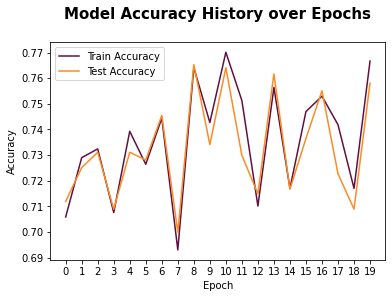

Train report:
Last train accuracy: 0.767
Last test accuracy: 0.758

Done!


In [144]:
# Step 5: Train the model using train_wrapper function

experiment_name = f'model-resnet18_dim-128x128_loss-crossentropy_optim-adam_lr-{LEARNING_RATE}_batch-{BATCH_SIZE}'

train_wrapper(model, trainer,
              train_dataloader=train_dataloader,
              val_dataloader=val_dataloader,
              test_dataloader=test_dataloader,
              epochs=EPOCHS,
              saved_model_name=f'{experiment_name}.pth',
              log_name=f'{experiment_name}.txt')